In [1]:
#!pip install matminer
from matminer.datasets import load_dataset

# Download and load the dataset
# The dataset is stored locally after being downloaded the first time
df = load_dataset("matbench_expt_gap")

# Check out the downloaded dataframe
print(df)

            composition  gap expt
0              Ag(AuS)2      0.00
1            Ag(W3Br7)2      0.00
2      Ag0.5Ge1Pb1.75S4      1.83
3     Ag0.5Ge1Pb1.75Se4      1.51
4                Ag2BBr      0.00
...                 ...       ...
4599             ZrTaN3      1.72
4600               ZrTe      0.00
4601             ZrTi2O      0.00
4602             ZrTiF6      0.00
4603               ZrW2      0.00

[4604 rows x 2 columns]


In [2]:
df.columns

Index(['composition', 'gap expt'], dtype='object')

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['composition'], df['gap expt'], test_size=0.25, random_state=123)

In [4]:
import pandas as pd
df_train = pd.DataFrame({"formula": X_train, "target": y_train})
df_test= pd.DataFrame({"formula": X_test, "target": y_test})

In [6]:
# !pip install crabnet

     |████████████████████████████████| 34.6 MB 285 kB/s 


In [7]:
# !pip3 install ax-platform

     |████████████████████████████████| 950 kB 5.2 MB/s 
     |████████████████████████████████| 347 kB 23.8 MB/s 
     |████████████████████████████████| 310 kB 33.3 MB/s 
  Created wheel for gpytorch: filename=gpytorch-1.6.0-py2.py3-none-any.whl size=509889 sha256=e3e194c38858de7e538875261994c062f6abe82f9509334e509a9cb4c45cd605
  Stored in directory: /root/.cache/pip/wheels/66/b5/89/34c06ad393a6feb72b4cdde46d0f1c667f3e2632960f9df109
Successfully built gpytorch


In [ ]:
import pprint
from os.path import join
from pathlib import Path
import numpy as np
import pandas as pd

import plotly.graph_objects as go

import gc
import torch

from ax.service.managed_loop import optimize
from ax.storage.json_store.save import save_experiment
from ax.plot.trace import optimization_trace_single_method
from crabnet.crabnet_ import CrabNet
from sklearn.metrics import mean_absolute_error

correct parameterization just converts from the Ax representation of CrabNet parameters to the CrabNet API for parameters.

In [ ]:
def correct_parameterization(parameterization):
    pprint.pprint(parameterization)

    parameterization["out_hidden"] = [
        parameterization.get("out_hidden4") * 8,
        parameterization.get("out_hidden4") * 4,
        parameterization.get("out_hidden4") * 2,
        parameterization.get("out_hidden4"),
    ]
    parameterization.pop("out_hidden4")

    parameterization["betas"] = (
        parameterization.get("betas1"),
        parameterization.get("betas2"),
    )
    parameterization.pop("betas1")
    parameterization.pop("betas2")

    d_model = parameterization["d_model"]

    # make heads even (unless it's 1) (because d_model must be even)
    heads = parameterization["heads"]
    if np.mod(heads, 2) != 0:
        heads = heads + 1
    parameterization["heads"] = heads

    # NOTE: d_model must be divisible by heads
    d_model = parameterization["heads"] * round(d_model / parameterization["heads"])

    parameterization["d_model"] = d_model

    parameterization["pos_scaler_log"] = (
        1 - parameterization["emb_scaler"] - parameterization["pos_scaler"]
    )

    parameterization["epochs"] = parameterization["epochs_step"] * 4

    return parameterization

In [18]:
def crabnet_evaluation(parameterization):
        """Compute the RMSE of a CrabNet model."""
        parameterization = correct_parameterization(parameterization)
        model= CrabNet(**parameterization, force_cpu=False, epochs=300)
        model.fit(df_train)
        y_predicted= model.predict(df_test)

        mae = mean_absolute_error(df_test['target'].to_list(), y_predicted)
        
        # deallocate CUDA memory https://discuss.pytorch.org/t/how-can-we-release-gpu-memory-cache/14530/28
        del crabnet_model
        gc.collect()
        torch.cuda.empty_cache()


        return {"mae":mae}

In [ ]:
best_parameters, best_values, experiment, model = optimize(
        parameters=[
          {"name": "batch_size", "type": "range", "bounds": [32, 256]},
          {"name": "fudge", "type": "range", "bounds": [0.0, 0.1]},
          {"name": "d_model", "type": "range", "bounds": [100, 1024]},
          {"name": "N", "type": "range", "bounds": [1, 10]},
          {"name": "heads", "type": "range", "bounds": [1, 10]},
          {"name": "out_hidden4", "type": "range", "bounds": [32, 512]},
          {"name": "emb_scaler", "type": "range", "bounds": [0.0, 1.0]},
          {"name": "pos_scaler", "type": "range", "bounds": [0.0, 1.0]},
          {"name": "bias", "type": "choice", "values": [False, True]},
          {"name": "dim_feedforward", "type": "range", "bounds": [1024, 4096],},
          {"name": "dropout", "type": "range", "bounds": [0.0, 1.0]},
          {
            "name": "elem_prop",
            "type": "choice",
            "values": ["mat2vec",
                    "oliynyk",
                    "magpie",
                    "onehot",],
          },
          {"name": "epochs_step", "type": "range", "bounds": [5, 20]},
          {"name": "pe_resolution", "type": "range", "bounds": [2500, 10000]},
          {"name": "ple_resolution", "type": "range", "bounds": [2500, 10000],},
          {
            "name": "criterion",
            "type": "choice",
            "values": ["RobustL1", "RobustL2"],
          },
          {"name": "lr", "type": "range", "bounds": [0.0001, 0.006]},
          {"name": "betas1", "type": "range", "bounds": [0.5, 0.9999]},
          {"name": "betas2", "type": "range", "bounds": [0.5, 0.9999]},
          {"name": "eps", "type": "range", "bounds": [0.0000001, 0.0001]},
          {"name": "weight_decay", "type": "range", "bounds": [0.0, 1.0]},
          {"name": "alpha", "type": "range", "bounds": [0.0, 1.0]},
          {"name": "k", "type": "range", "bounds": [2, 10]},
        ],
        experiment_name="crabnet-hyperparameter_tuning",
        evaluation_function=crabnet_evaluation,
        objective_name="mae",
        minimize=True,
        parameter_constraints=["betas1 <= betas2", "emb_scaler + pos_scaler <= 1"],
        total_trials= 100)

print(best_parameters)
print(best_values)

default_model= CrabNet(force_cpu=False, epochs=300)
default_model.fit(df_train)
default_y_predicted= default_model.predict(df_test)
default_mae = mean_absolute_error(df_test['target'].to_list(), default_y_predicted)

del default_model
gc.collect()
torch.cuda.empty_cache()

best_parameterization = correct_parameterization(best_parameters)
test_model = CrabNet(**best_parameterization, force_cpu=False, epochs=300)
test_model.fit(df_train)
test_y_predicted= test_model.predict(df_test)
test_mae = mean_absolute_error(df_test['target'].to_list(), test_y_predicted)

del test_model
gc.collect()
torch.cuda.empty_cache()



In [ ]:
mb = MatbenchBenchmark(autoload=False, subset=["matbench_expt_gap"])
kf = KFold(n_splits=n_splits, shuffle=True, random_state=18012019)

task = list(mb.tasks)[0]
task.load()
for i, fold in enumerate(task.folds):
    train_inputs, train_outputs = task.get_train_and_val_data(fold)

    # TODO: treat train_val_df as Ax fixed_parameter
    train_val_df = pd.DataFrame(
        {"formula": train_inputs.values, "target": train_outputs.values}
    )
    if dummy:
        train_val_df = train_val_df[:100]

    def crabnet_mae(parameterization):
        """Compute the mean absolute error of a CrabNet model.
        
        Assumes that `train_df` and `val_df` are predefined.

        Parameters
        ----------
        parameterization : dict
            Dictionary of the parameters passed to `get_model()` after some slight
            modification. 

        Returns
        -------
        results: dict
            Dictionary of `{"rmse": rmse}` where `rmse` is the root-mean-square error of the
            CrabNet model.
        """
        parameterization = correct_parameterization(parameterization)

        mae = 0.0
        for train_index, val_index in kf.split(train_val_df):
            train_df, val_df = (
                train_val_df.loc[train_index],
                train_val_df.loc[val_index],
            )
            crabnet_model = get_model(
                mat_prop="expt_gap",
                train_df=train_df,
                learningcurve=False,
                force_cpu=False,
                **parameterization
            )
            val_true, val_pred, val_formulas, val_sigma = crabnet_model.predict(val_df)
            # rmse = mean_squared_error(val_true, val_pred, squared=False)
            mae = mae + mean_absolute_error(val_true, val_pred)

            # deallocate CUDA memory https://discuss.pytorch.org/t/how-can-we-release-gpu-memory-cache/14530/28
            del crabnet_model
            gc.collect()
            torch.cuda.empty_cache()
        mae = mae / n_splits
        results = {"mae": mae}
        return results

    best_parameters, values, experiment, model = optimize(
        parameters=[
            {"name": "batch_size", "type": "range", "bounds": [32, 256]},
            {"name": "fudge", "type": "range", "bounds": [0.0, 0.1]},
            {"name": "d_model", "type": "range", "bounds": [100, 1024]},
            {"name": "N", "type": "range", "bounds": [1, 10]},
            {"name": "heads", "type": "range", "bounds": [1, 10]},
            {"name": "out_hidden4", "type": "range", "bounds": [32, 512]},
            {"name": "emb_scaler", "type": "range", "bounds": [0.0, 1.0]},
            {"name": "pos_scaler", "type": "range", "bounds": [0.0, 1.0]},
            {"name": "bias", "type": "choice", "values": [False, True]},
            {"name": "dim_feedforward", "type": "range", "bounds": [1024, 4096],},
            {"name": "dropout", "type": "range", "bounds": [0.0, 1.0]},
            # jarvis and oliynyk don't have enough elements
            # ptable contains str, which isn't a handled case
            {
                "name": "elem_prop",
                "type": "choice",
                "values": [
                    "mat2vec",
                    "magpie",
                    "onehot",
                ],  # "jarvis", "oliynyk", "ptable"
            },
            {"name": "epochs_step", "type": "range", "bounds": [5, 20]},
            {"name": "pe_resolution", "type": "range", "bounds": [2500, 10000]},
            {"name": "ple_resolution", "type": "range", "bounds": [2500, 10000],},
            {
                "name": "criterion",
                "type": "choice",
                "values": ["RobustL1", "RobustL2"],
            },
            {"name": "lr", "type": "range", "bounds": [0.0001, 0.006]},
            {"name": "betas1", "type": "range", "bounds": [0.5, 0.9999]},
            {"name": "betas2", "type": "range", "bounds": [0.5, 0.9999]},
            {"name": "eps", "type": "range", "bounds": [0.0000001, 0.0001]},
            {"name": "weight_decay", "type": "range", "bounds": [0.0, 1.0]},
            # {"name": "adam", "type": "choice", "values": [False, True]}, # issues with onehot
            # {"name": "min_trust", "type": "range", "bounds": [0.0, 1.0]}, #issues with onehot
            {"name": "alpha", "type": "range", "bounds": [0.0, 1.0]},
            {"name": "k", "type": "range", "bounds": [2, 10]},
        ],
        experiment_name="crabnet-hyperparameter",
        evaluation_function=crabnet_mae,
        objective_name="mae",
        minimize=True,
        parameter_constraints=["betas1 <= betas2", "emb_scaler + pos_scaler <= 1"],
        total_trials=total_trials,
    )
    print(best_parameters)
    print(values)

    experiment_fpath = join(experiment_dir, "experiment" + str(i) + ".json")
    save_experiment(experiment, experiment_fpath)

    # TODO: save plot, save experiment

    test_inputs, test_outputs = task.get_test_data(fold, include_target=True)

    test_df = pd.DataFrame({"formula": test_inputs, "target": test_outputs})

    default_model = get_model(
        mat_prop="expt_gap",
        train_df=train_val_df,
        learningcurve=False,
        force_cpu=False,
    )

    default_true, default_pred, default_formulas, default_sigma = default_model.predict(
        test_df
    )
    # rmse = mean_squared_error(val_true, val_pred, squared=False)
    default_mae = mean_absolute_error(default_true, default_pred)

    # deallocate CUDA memory https://discuss.pytorch.org/t/how-can-we-release-gpu-memory-cache/14530/28
    del default_model
    gc.collect()
    torch.cuda.empty_cache()

    best_parameterization = correct_parameterization(best_parameters)
    test_model = get_model(
        mat_prop="expt_gap",
        train_df=train_val_df,
        learningcurve=False,
        force_cpu=False,
        **best_parameterization
    )
    # TODO: update CrabNet predict function to allow for no target specified
    test_true, test_pred, test_formulas, test_sigma = test_model.predict(test_df)
    # rmse = mean_squared_error(val_true, val_pred, squared=False)
    test_mae = mean_absolute_error(test_true, test_pred)

    # deallocate CUDA memory https://discuss.pytorch.org/t/how-can-we-release-gpu-memory-cache/14530/28
    del test_model
    gc.collect()
    torch.cuda.empty_cache()

    trials = experiment.trials.values()

    best_objectives = np.array([[trial.objective_mean for trial in trials]])

    parameter_strs = [
        pprint.pformat(trial.arm.parameters).replace("\n", "<br>") for trial in trials
    ]

    best_objective_plot = optimization_trace_single_method(
        y=best_objectives,
        optimization_direction="minimize",
        ylabel="MAE (eV)",
        hover_labels=parameter_strs,
        plot_trial_points=True,
    )

    figure_fpath = join(figure_dir, "best_objective_plot_" + str(i))

    data = best_objective_plot[0]["data"]

    data.append(
        go.Scatter(
            x=(1, total_trials),
            y=(default_mae, default_mae),
            mode="lines",
            line={"dash": "dash"},
            name="default MAE",
            yaxis="y1",
        )
    )

    data.append(
        go.Scatter(
            x=(1, total_trials),
            y=(test_mae, test_mae),
            mode="lines",
            line={"dash": "dash"},
            name="best model test MAE",
            yaxis="y1",
        )
    )

    layout = best_objective_plot[0]["layout"]

    fig = go.Figure({"data": data, "layout": layout})

    fig.show()
    fig.write_html(figure_fpath + ".html")
    fig.to_json(figure_fpath + ".json")
    fig.update_layout(
        legend=dict(
            font=dict(size=16),
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.99,
            bgcolor="rgba(0,0,0,0)",
        )
    )
    fig, scale = matplotlibify(fig)
    fig.write_image(figure_fpath + ".png")

    task.record(fold, test_pred, params=best_parameterization)


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11987206 parameters



Generating EDM: 100%|██████████| 2762/2762 [00:00<00:00, 83477.46formulae/s]


loading data with up to 4 elements in the formula
training with batchsize 56 (2**5.807)


Generating EDM: 100%|██████████| 691/691 [00:00<00:00, 98093.28formulae/s]


loading data with up to 4 elements in the formula
stepping every 500 training passes, cycling lr every 10 epochs
checkin at 20 epochs to match lr scheduler
Epoch: 0/100 --- train mae: 0.971 val mae: 0.953


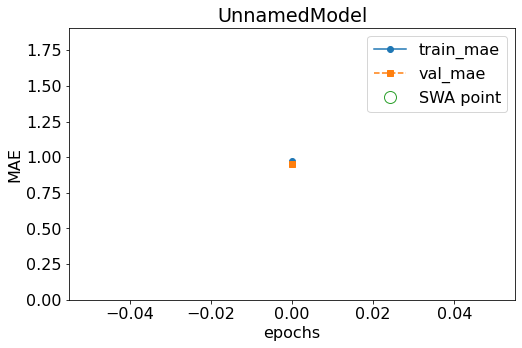

KeyboardInterrupt: 

In [20]:
from sklearn.metrics import mean_absolute_error
# Fitting the model with the best parameters

Crabnet_Ax = CrabNet(**best_parameters, epochs=100) # bias=...., batch_size=....., dropout=....., elem_prop='......')
Crabnet_Ax.fit(df_train)
y_pred_Ax = Crabnet_Ax.predict(df_test)
mae_Ax = mean_absolute_error(df_test['target'].to_list(), y_pred_Ax)

In [ ]:
# Fitting the model with default parameters

default_Model = CrabNet(epochs=100)
default_Model.fit(df_train)
y_pred_default = default_Model.predict(df_test)
mae_default = mean_absolute_error(df_test['target'].to_list(), y_pred_default)